# Time series forecasting for confirmed cases in Italy using LSTM model

In [126]:
!pip install tensorflow==2.2.0

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\~cipy\\cluster\\_hierarchy.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.2
    Uninstalling scipy-1.5.2:
      Successfully uninstalled scipy-1.5.2


In [128]:
!pip install keras==2.4.3

# importing and reading the 3 datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

%matplotlib inline

In [2]:
df_con = pd.read_csv('time_series_covid19_confirmed_global.csv',index_col='Country/Region')
df_d = pd.read_csv('time_series_covid19_deaths_global.csv',index_col='Country/Region')
df_r = pd.read_csv('time_series_covid19_recovered_global.csv',index_col='Country/Region')

## dropping the irrelevant columns

In [3]:
df1 = df_con.drop(['Province/State','Long','Lat'],axis=1)
df2 = df_d.drop(['Province/State','Long','Lat'],axis=1)
df3 = df_r.drop(['Province/State','Long','Lat'],axis=1)

## Swapping rows and columns to get the date as index column

In [4]:
df_con_trans =df1.transpose()
df_d_trans =df2.transpose()
df_r_trans =df3.transpose()

In [12]:
data1 = df_con_trans.loc[:,['Italy']]
data2 = df_d_trans.loc[:,['Italy']]
data3 = df_r_trans.loc[:,['Italy']]

## Loc India from all the 3 datasets to make a new dataset with
- India confirmed Case
- India deaths
- India recovered cases

In [13]:
data = pd.concat([data1,data2,data3],axis=1)

In [14]:
data

Country/Region,Italy,Italy,Italy
1/22/20,0,0,0
1/23/20,0,0,0
1/24/20,0,0,0
1/25/20,0,0,0
1/26/20,0,0,0
...,...,...,...
9/17/20,293025,35658,215954
9/18/20,294932,35668,216807
9/19/20,296569,35692,217716
9/20/20,298156,35707,218351


In [15]:
data.reset_index(inplace = True)

In [16]:
data

Country/Region,index,Italy,Italy,Italy
0,1/22/20,0,0,0
1,1/23/20,0,0,0
2,1/24/20,0,0,0
3,1/25/20,0,0,0
4,1/26/20,0,0,0
...,...,...,...,...
239,9/17/20,293025,35658,215954
240,9/18/20,294932,35668,216807
241,9/19/20,296569,35692,217716
242,9/20/20,298156,35707,218351


## Renaming the columns
## changing dates to datetime format
## making the list of columns and dates

In [17]:
data.columns=['Date','Italy_conf','Italy_deaths','Italy_recov']

In [18]:
cols = list(data)[1:4]

In [19]:
training_dates = pd.to_datetime(data['Date'])

In [20]:
training_dates = list(training_dates)

In [21]:
training_dates[-1]

Timestamp('2020-09-21 00:00:00')

In [22]:
df_for_training = data[cols].astype(float)

In [23]:
len(df_for_training)

244

## Scaling the data

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

## Seperating training data and testing data
### n_future is 20 and n_past is 30
- ie for datas from 1 to 30 , 31 to 50 will be the predicted
- for datas from 2 to 31,   32 to 51 will be predicted
- this will be carried on for the full dataset

In [26]:
train_X = []
train_Y = []

In [27]:
n_future=20
n_past = 30

In [28]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    train_X.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    train_Y.append(df_for_training_scaled[i+n_future-1:i+n_future,0])

In [29]:
train_X, train_Y = np.array(train_X),np.array(train_Y)

In [30]:
print(train_X.shape)
print(train_Y.shape)

(195, 30, 3)
(195, 1)


# Applying the LSTM model 
- Activcation function relu
- Dropout to avoid overfitting
- optimizer 'adam'

In [31]:
from keras.models import Sequential
from keras.layers import LSTM
from keras .layers import Dropout
from keras.layers import Dense

In [32]:

model = Sequential()

In [33]:
model.add(LSTM(64,activation='relu',input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[1]))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


# Training the model with 50 epochs and validation split = 0.2

In [36]:
history = model.fit(train_X,train_Y,epochs=50,
                             validation_split=0.2,
                             batch_size=15,
                    verbose=1)

Epoch 1/50
11/11 [==============================] - 4s 98ms/step - loss: 0.6410 - val_loss: 0.6887
Epoch 2/50
11/11 [==============================] - 0s 29ms/step - loss: 0.3536 - val_loss: 0.2179
Epoch 3/50
11/11 [==============================] - 0s 31ms/step - loss: 0.1284 - val_loss: 0.0044
Epoch 4/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0536 - val_loss: 0.0021
Epoch 5/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0424 - val_loss: 0.0152
Epoch 6/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0322 - val_loss: 0.0084
Epoch 7/50
11/11 [==============================] - 0s 31ms/step - loss: 0.0320 - val_loss: 0.0129
Epoch 8/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0303 - val_loss: 0.0081
Epoch 9/50
11/11 [==============================] - 0s 31ms/step - loss: 0.0290 - val_loss: 0.0030
Epoch 10/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0251 - val_loss: 0.0079
Epoch 11/

## Forecasting for next 90 days

In [54]:
n_future=90

In [95]:
forecast_period_dates = pd.date_range(list(training_dates)[-10],periods=n_future,freq='1d').tolist()

In [96]:
forecast_period_dates

[Timestamp('2020-09-12 00:00:00', freq='D'),
 Timestamp('2020-09-13 00:00:00', freq='D'),
 Timestamp('2020-09-14 00:00:00', freq='D'),
 Timestamp('2020-09-15 00:00:00', freq='D'),
 Timestamp('2020-09-16 00:00:00', freq='D'),
 Timestamp('2020-09-17 00:00:00', freq='D'),
 Timestamp('2020-09-18 00:00:00', freq='D'),
 Timestamp('2020-09-19 00:00:00', freq='D'),
 Timestamp('2020-09-20 00:00:00', freq='D'),
 Timestamp('2020-09-21 00:00:00', freq='D'),
 Timestamp('2020-09-22 00:00:00', freq='D'),
 Timestamp('2020-09-23 00:00:00', freq='D'),
 Timestamp('2020-09-24 00:00:00', freq='D'),
 Timestamp('2020-09-25 00:00:00', freq='D'),
 Timestamp('2020-09-26 00:00:00', freq='D'),
 Timestamp('2020-09-27 00:00:00', freq='D'),
 Timestamp('2020-09-28 00:00:00', freq='D'),
 Timestamp('2020-09-29 00:00:00', freq='D'),
 Timestamp('2020-09-30 00:00:00', freq='D'),
 Timestamp('2020-10-01 00:00:00', freq='D'),
 Timestamp('2020-10-02 00:00:00', freq='D'),
 Timestamp('2020-10-03 00:00:00', freq='D'),
 Timestamp

In [97]:
forecast = model.predict(train_X[-n_future:])

In [98]:
forecast

array([[0.7468041 ],
       [0.74816644],
       [0.7495283 ],
       [0.75086844],
       [0.75217915],
       [0.7534864 ],
       [0.7547871 ],
       [0.75609434],
       [0.7573916 ],
       [0.75869   ],
       [0.75998616],
       [0.7612599 ],
       [0.7625077 ],
       [0.763729  ],
       [0.7649312 ],
       [0.76610446],
       [0.7672415 ],
       [0.7683321 ],
       [0.76937056],
       [0.7703575 ],
       [0.7713139 ],
       [0.7722428 ],
       [0.77314603],
       [0.77402055],
       [0.77486086],
       [0.77565646],
       [0.7764183 ],
       [0.7771493 ],
       [0.7778537 ],
       [0.77853143],
       [0.77918637],
       [0.779812  ],
       [0.78040624],
       [0.78097653],
       [0.7815335 ],
       [0.78207743],
       [0.7826103 ],
       [0.78312767],
       [0.78363144],
       [0.78411794],
       [0.7845875 ],
       [0.7850472 ],
       [0.78549945],
       [0.78594494],
       [0.78638697],
       [0.7868211 ],
       [0.7872453 ],
       [0.787

## original data is of 3 dimension,so making forecast data same dimension

In [99]:
forecast_copies = np.repeat(forecast,df_for_training.shape[1],axis=-1)

In [100]:
forecast_copies


array([[0.7468041 , 0.7468041 , 0.7468041 ],
       [0.74816644, 0.74816644, 0.74816644],
       [0.7495283 , 0.7495283 , 0.7495283 ],
       [0.75086844, 0.75086844, 0.75086844],
       [0.75217915, 0.75217915, 0.75217915],
       [0.7534864 , 0.7534864 , 0.7534864 ],
       [0.7547871 , 0.7547871 , 0.7547871 ],
       [0.75609434, 0.75609434, 0.75609434],
       [0.7573916 , 0.7573916 , 0.7573916 ],
       [0.75869   , 0.75869   , 0.75869   ],
       [0.75998616, 0.75998616, 0.75998616],
       [0.7612599 , 0.7612599 , 0.7612599 ],
       [0.7625077 , 0.7625077 , 0.7625077 ],
       [0.763729  , 0.763729  , 0.763729  ],
       [0.7649312 , 0.7649312 , 0.7649312 ],
       [0.76610446, 0.76610446, 0.76610446],
       [0.7672415 , 0.7672415 , 0.7672415 ],
       [0.7683321 , 0.7683321 , 0.7683321 ],
       [0.76937056, 0.76937056, 0.76937056],
       [0.7703575 , 0.7703575 , 0.7703575 ],
       [0.7713139 , 0.7713139 , 0.7713139 ],
       [0.7722428 , 0.7722428 , 0.7722428 ],
       [0.

## inversing the scale

In [101]:
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [102]:
forecast_dates = []

## adding the days to predict

In [103]:
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [104]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates),'Italy_conf':y_pred_future})

In [105]:
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [106]:
original =data[['Date','Italy_conf']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date']>='2020-03-22']

<ipython-input-106-97dcfd4cc311>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


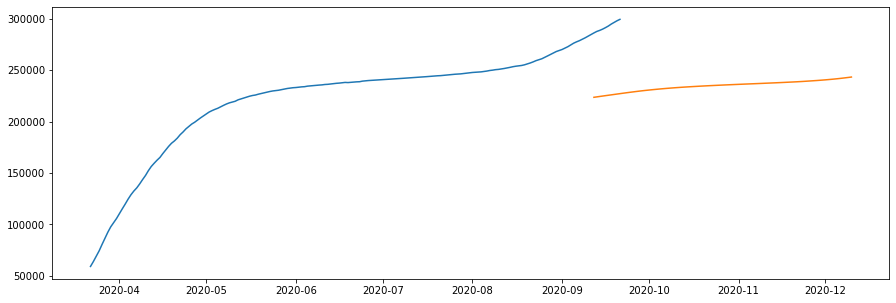

In [107]:
from pylab import rcParams
rcParams['figure.figsize']=15,5
plt.plot(original['Date'],original['Italy_conf'])
plt.plot(df_forecast['Date'],df_forecast['Italy_conf'])


## Blue line represents the original data 
## orange line forecasting for further 90 days